# Transformer Model
트랜스포머 모델 훈련을 통해 주식 종가를 예측  
10개의 타임스텝 -> 1개의 타임스텝 예측

Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import math
import random
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

데이터 불러오기 및 전역 변수 설정

In [3]:
input_window = 10 # input 타임
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 250 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

df = pd.read_csv('./Data/kodex200_data.csv') # 데이터 불러오기
close = np.array(df['종가'])
logreturn = np.diff(np.log(close)) # Min-max 스케일러 대신, 로그변환을 통한 스케일링

csum_logreturn = logreturn.cumsum() # 누적로그수익률누적로그수익률

스케일링된 데이터 시각화

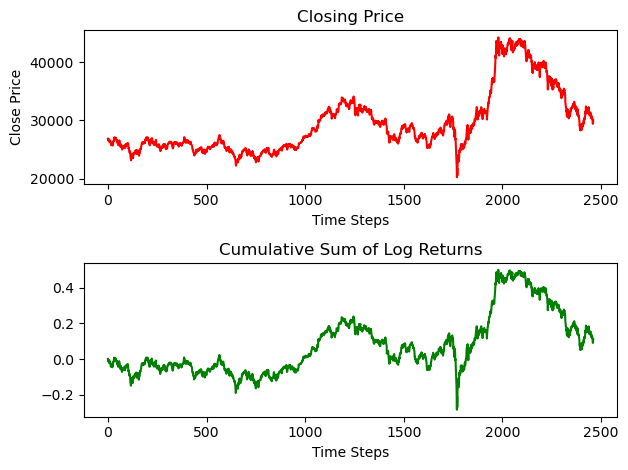

In [6]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(close, color='red')
axs[0].set_title('Closing Price')
axs[0].set_ylabel('Close Price')
axs[0].set_xlabel('Time Steps')

axs[1].plot(csum_logreturn, color='green')
axs[1].set_title('Cumulative Sum of Log Returns')
axs[1].set_xlabel('Time Steps')

fig.tight_layout()
plt.show()

Positional Encoder

In [7]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]       

Transformer Model

In [8]:
class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

window에 따라 시퀀스 데이터를 나눈다

In [9]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        # train_label -> input window만큼 훈련 후 output data 
        train_label = input_data[i+output_window:i+tw+output_window] 
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

train/test 데이터 분리, windowed 시퀀스 데이터 준비

In [10]:
def get_data(data, split):
    # split : train/test 분리 비율

    series = data
    
    split = round(split*len(series)) 
    train_data = series[:split]
    test_data = series[split:]

    # 데이터를 누적 합으로 변환 -> 데이터의 절대적인 값보다는 상대적인 변화에 집중
    train_data = train_data.cumsum()
    # 훈련 데이터의 값을 2배로 스케일링하여 모델이 더 잘 일반화하도록 돕는 데이터 증강(data augmentation) 과정
    train_data = 2*train_data 
    
    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window]

    return train_sequence.to(device), test_data.to(device)

훈련 배치 사이즈만큼 나눈다

In [11]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target

훈련 함수

In [12]:
def train(model,train_data, optimizer, criterion, scheduler, epoch):
    model.train() 
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

모델 평가 함수

In [13]:
def evaluate(eval_model, criterion, data_source):
    eval_model.eval() # 평가 모드로 전환
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)            
            total_loss += len(data[0])* criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

전체 시퀀스에 대해 예측하는 함수

In [14]:
def forecast_seq(model, sequences):
    # 시퀀스 데이터는 window되어 있어야 한다
    # 예측 시퀀스와 실제 값 반환
    start_timer = time.time()
    model.eval() 
    forecast_seq = torch.Tensor(0)    
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)            
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, target[-1].view(-1).cpu()), 0)
    timed = time.time()-start_timer
    print(f"{timed} sec")

    
    return forecast_seq, actual

데이터 준비 및 훈련

In [15]:
train_data, val_data = get_data(logreturn, 0.8) # 80% train, 20% test split
model = TransAm().to(device)

/var/folders/82/yjz_v88n7jnb6641bk83qtvw0000gn/T/ipykernel_52590/219410700.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343679700/work/torch/csrc/utils/tensor_new.cpp:248.)
  return torch.FloatTensor(inout_seq)


모델 파라미터

In [16]:
criterion = nn.MSELoss() # Loss function
lr = 0.00005 # learning rate

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

epochs =  5 # Number of epochs

Training loop

In [17]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, train_data, optimizer, criterion, scheduler, epoch)
    
    if(epoch % epochs == 0): # 마지막 에포치 끝난 후 모델 평가
        val_loss = evaluate(model, criterion, val_data)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch, (time.time() - epoch_start_time), val_loss))
        print('-' * 80)

    else:   
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)

    scheduler.step()


/Users/ihobbang/opt/anaconda3/envs/main/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     1/    5 batches | lr 0.0000500000 | 392.89 ms | loss 2.2902442
| epoch   1 |     2/    5 batches | lr 0.0000500000 | 175.55 ms | loss 0.1656863
| epoch   1 |     3/    5 batches | lr 0.0000500000 | 165.65 ms | loss 1.2518631
| epoch   1 |     4/    5 batches | lr 0.0000500000 | 155.94 ms | loss 0.9656614
| epoch   1 |     5/    5 batches | lr 0.0000500000 | 115.84 ms | loss 0.6117653
--------------------------------------------------------------------------------
| end of epoch   1 | time:  1.01s
--------------------------------------------------------------------------------
| epoch   2 |     1/    5 batches | lr 0.0000451250 | 323.99 ms | loss 0.3611259
| epoch   2 |     2/    5 batches | lr 0.0000451250 | 164.16 ms | loss 0.0646658
| epoch   2 |     3/    5 batches | lr 0.0000451250 | 161.42 ms | loss 0.1045437
| epoch   2 |     4/    5 batches | lr 0.0000451250 | 166.08 ms | loss 0.1541144
| epoch   2 |     5/    5 batches | lr 0.0000451250 | 106.70 ms | loss 0.38

In [18]:
test_result, truth = forecast_seq(model, val_data)

0.033817291259765625 sec


forecasted sequence vs actual 시각화

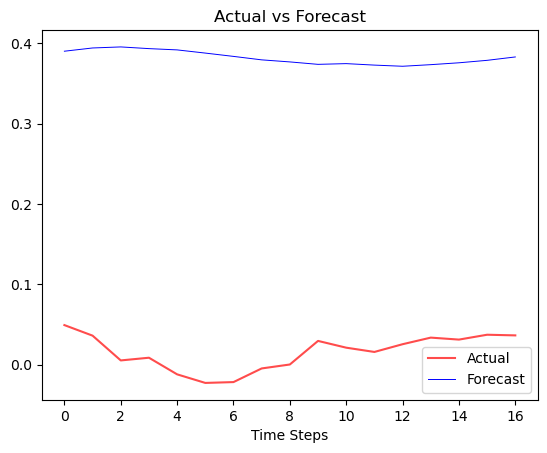

In [19]:
plt.plot(truth, color='red', alpha=0.7)
plt.plot(test_result, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()

Save model

In [20]:
torch.save(model.state_dict(), "transformer_ts.pth")

Load model

In [21]:
model2 = TransAm() # rename as model2
model2.load_state_dict(torch.load("transformer_ts.pth"))
model2.to(device)

TransAm(
  (pos_encoder): PositionalEncoding()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=250, out_features=250, bias=True)
    )
    (linear1): Linear(in_features=250, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=250, bias=True)
    (norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=250, out_features=250, bias=True)
        )
        (linear1): Linear(in_features=250, out_features=2048, bias=True)
        (dropout): Dropout

같은 기간동안 NAV데이터 예측

In [22]:
close2 = df['NAV'].fillna(method = 'ffill')
close2 = np.array(close2)
logreturn2 = np.diff(np.log(close2))

In [23]:
train_data2, val_data2 = get_data(logreturn2, 0.8)
test2_eval = evaluate(model2, criterion ,val_data2)
print(f'Test 2 loss: {test2_eval :.5f}')

Test 2 loss: 0.22584


0.8535761833190918 sec


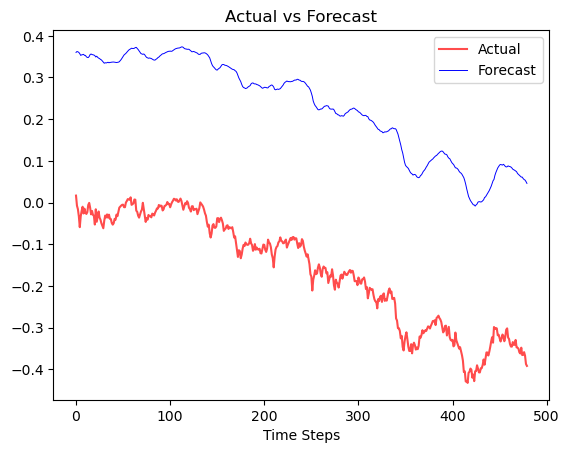

In [24]:
test_result2, truth2 = forecast_seq(model2, val_data2)

plt.plot(truth2, color='red', alpha=0.7)
plt.plot(test_result2, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()